In [1]:
import pandas as pd
from scipy.sparse import coo_matrix, csr_matrix

# import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import pickle
from function import *
from sklearn.model_selection import train_test_split

from implicit.als import AlternatingLeastSquares
from implicit.evaluation import mean_average_precision_at_k

import multiprocessing
num_threads = multiprocessing.cpu_count()

In [2]:
import os
import threadpoolctl

os.environ['MKL_NUM_THREADS'] = '5'
os.environ['OPENBLAS_NUM_THREADS'] = '5'
os.environ['OMP_NUM_THREADS'] = '5'

threadpoolctl.threadpool_limits(5, "blas")

In [3]:
# # # Производим десериализацию и извлекаем из файла формата pkl
with open('data/events.pkl', 'rb') as pkl_file:
    events = pickle.load(pkl_file)

with open('data/category_tree.pkl', 'rb') as pkl_file:
    category_tree = pickle.load(pkl_file)

with open('data/item_properties.pkl', 'rb') as pkl_file:
    item_properties = pickle.load(pkl_file)

In [4]:
display(events.head(3))
display(category_tree.head(3))
display(item_properties.head(3))

,timestamp,visitorid,event,itemid,transactionid,day_of_week,year,month,day,hour,minute,part_day,Day Period
0,2015-06-02 05:02:12.117,257597,view,355908,NaN,1,2015,6,2,5,2,Morning,Dawn
1,2015-06-02 05:50:14.164,992329,view,248676,NaN,1,2015,6,2,5,50,Morning,Dawn
2,2015-06-02 05:13:19.827,111016,view,318965,NaN,1,2015,6,2,5,13,Morning,Dawn


,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0


,timestamp,itemid,property,value
0,2015-06-28,460429,categoryid,1338
1,2015-09-06,206783,888,1116713 960601 n277.200
2,2015-08-09,395014,400,n552.000 639502 n720.000 424566


In [5]:
events['timestamp'] = pd.to_datetime(events['timestamp'])
item_properties['timestamp'] = pd.to_datetime(item_properties['timestamp'])

In [6]:
events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2755641 entries, 0 to 2756100
Data columns (total 13 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      datetime64[ns]
 1   visitorid      int64         
 2   event          object        
 3   itemid         int64         
 4   transactionid  float64       
 5   day_of_week    int32         
 6   year           int32         
 7   month          int32         
 8   day            int32         
 9   hour           int32         
 10  minute         int32         
 11  part_day       object        
 12  Day Period     object        
dtypes: datetime64[ns](1), float64(1), int32(6), int64(2), object(3)
memory usage: 231.3+ MB


In [7]:
category_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


In [8]:
item_properties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20275902 entries, 0 to 20275901
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   timestamp  datetime64[ns]
 1   itemid     int64         
 2   property   object        
 3   value      object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 618.8+ MB


# Исследование данных

### Описание структуры данных  
### Статистический анализ данных

Типы событий array(['view', 'addtocart', 'transaction'], dtype=object).  
Проверим, что деньги списываются, только при проведении транзакции, а при просмотре или добавлении товара в корзину.

In [9]:
events[events['event'] != 'transaction']['transactionid'].unique()

array([nan])

In [10]:
events.describe(include='all')

,timestamp,visitorid,event,itemid,transactionid,day_of_week,year,month,day,hour,minute,part_day,Day Period
count,2755641,2.755641e+06,2755641,2.755641e+06,22457.000000,2.755641e+06,2755641.0,2.755641e+06,2.755641e+06,2.755641e+06,2.755641e+06,2755641,2755641
unique,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,5
top,NaN,NaN,view,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Evening,Evening
freq,NaN,NaN,2664218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1092194,1078018
mean,2015-07-09 06:46:18.779006720,7.019227e+05,NaN,2.349214e+05,8826.497796,2.763684e+00,2015.0,6.771041e+00,1.539001e+01,1.279448e+01,2.969774e+01,NaN,NaN
min,2015-05-03 03:00:04.384000,0.000000e+00,NaN,3.000000e+00,0.000000,0.000000e+00,2015.0,5.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN
25%,2015-06-05 04:21:34.039000064,3.505660e+05,NaN,1.181200e+05,4411.000000,1.000000e+00,2015.0,6.000000e+00,8.000000e+00,4.000000e+00,1.500000e+01,NaN,NaN
50%,2015-07-09 14:39:51.604000,7.020600e+05,NaN,2.360620e+05,8813.000000,3.000000e+00,2015.0,7.000000e+00,1.500000e+01,1.600000e+01,3.000000e+01,NaN,NaN
75%,2015-08-10 16:44:03.217999872,1.053443e+06,NaN,3.507140e+05,13224.000000,4.000000e+00,2015.0,8.000000e+00,2.300000e+01,2.000000e+01,4.500000e+01,NaN,NaN
max,2015-09-18 02:59:47.788000,1.407579e+06,NaN,4.668670e+05,17671.000000,6.000000e+00,2015.0,9.000000e+00,3.100000e+01,2.300000e+01,5.900000e+01,NaN,NaN


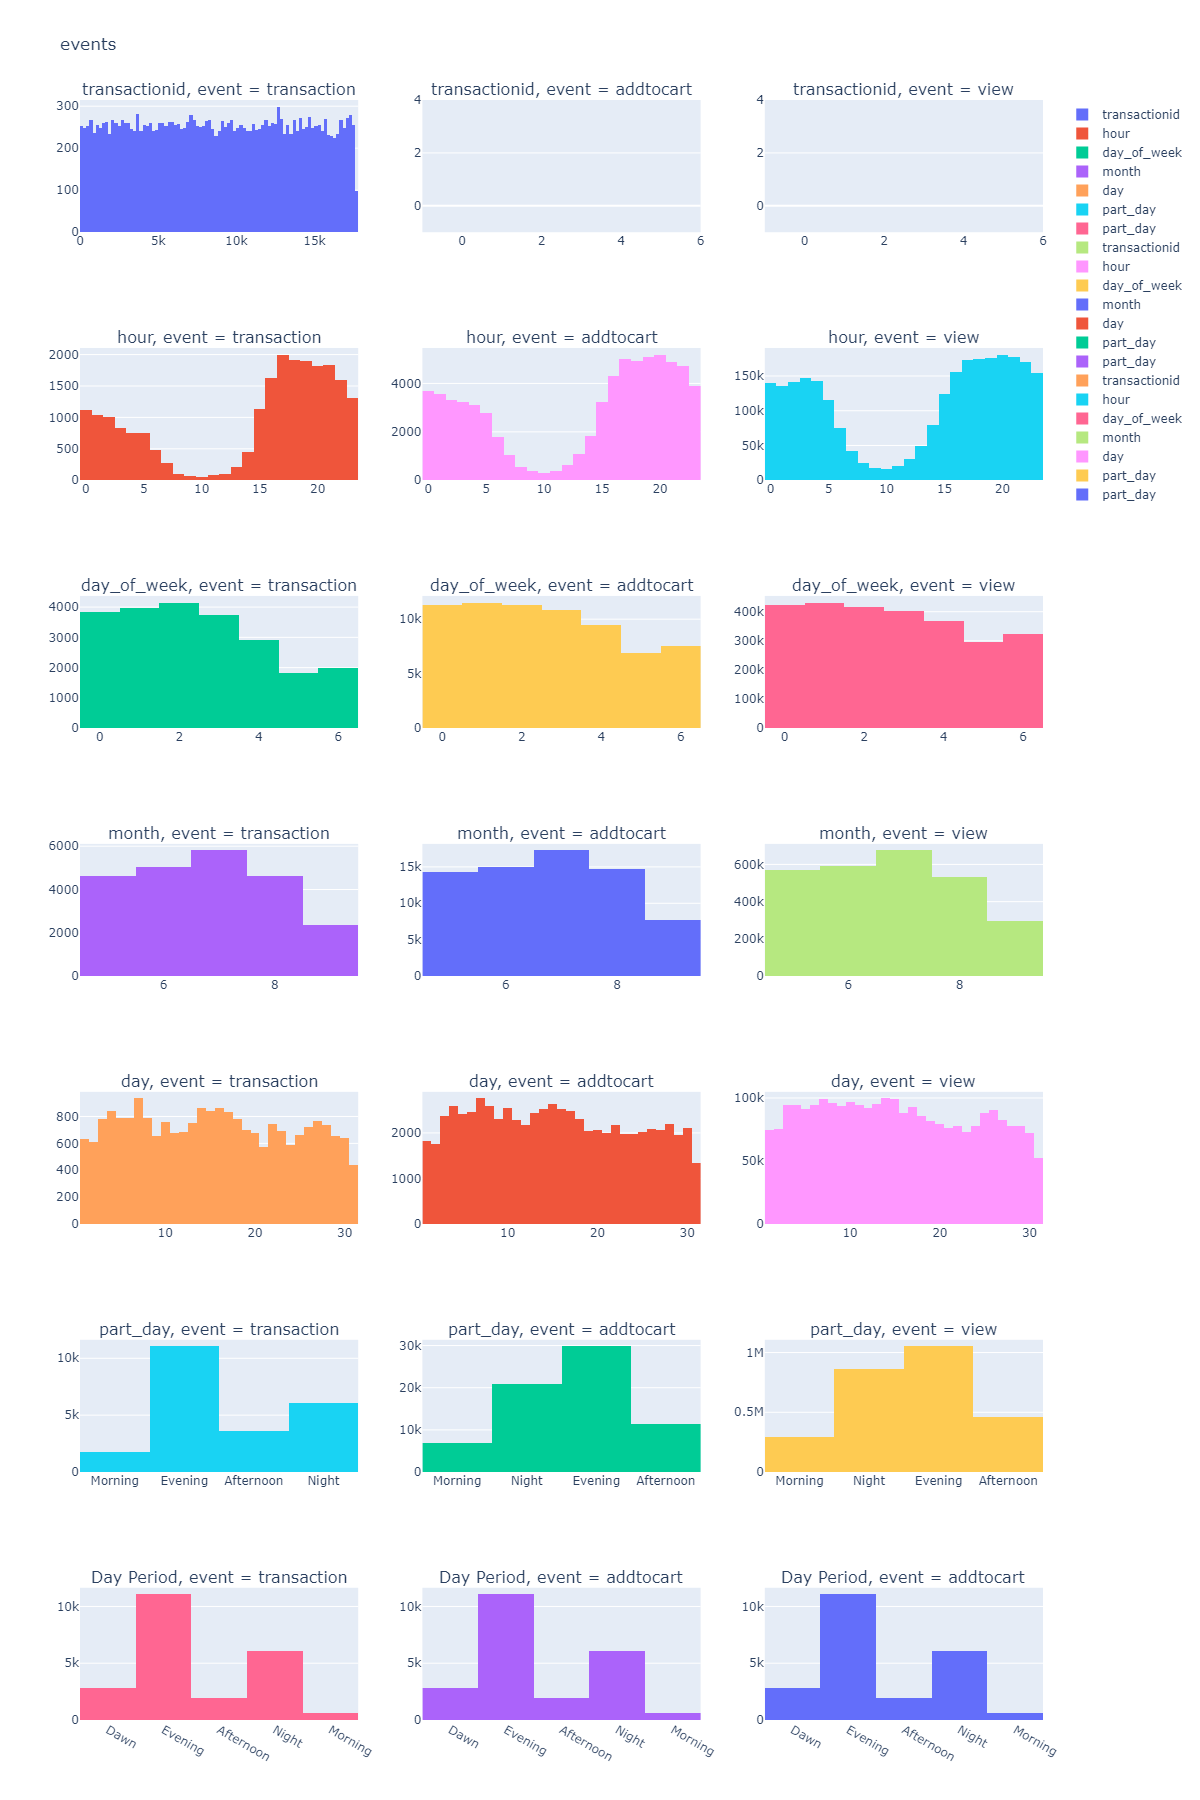

In [11]:
fig = make_subplots(
    rows=7, cols=3,
    subplot_titles=['transactionid, event = transaction',
                    'transactionid, event = addtocart',
                    'transactionid, event = view',
                    'hour, event = transaction',
                    'hour, event = addtocart',
                    'hour, event = view',
                    'day_of_week, event = transaction',
                    'day_of_week, event = addtocart',
                    'day_of_week, event = view',
                    'month, event = transaction',
                    'month, event = addtocart',
                    'month, event = view',
                    'day, event = transaction',
                    'day, event = addtocart',
                    'day, event = view',
                    'part_day, event = transaction',
                    'part_day, event = addtocart',
                    'part_day, event = view',
                    'Day Period, event = transaction',
                    'Day Period, event = addtocart',
                    'Day Period, event = addtocart'
                    ])

trace00 = go.Histogram(x=events[events['event'] == 'transaction']['transactionid'],
                       orientation='v', name='transactionid')
trace01 = go.Histogram(x=events[events['event'] == 'transaction']['hour'],
                       orientation='v', name='hour')
trace02 = go.Histogram(x=events[events['event'] == 'transaction']['day_of_week'],
                       orientation='v', name='day_of_week')
trace03 = go.Histogram(x=events[events['event'] == 'transaction']['month'],
                       orientation='v', name='month')
trace04 = go.Histogram(x=events[events['event'] == 'transaction']['day'],
                       orientation='v', name='day')
trace05 = go.Histogram(x=events[events['event'] == 'transaction']['part_day'],
                       orientation='v', name='part_day')
trace06 = go.Histogram(x=events[events['event'] == 'transaction']['Day Period'],
                       orientation='v', name='part_day')

trace07 = go.Histogram(x=events[events['event'] == 'addtocart']['transactionid'],
                       orientation='v', name='transactionid')
trace08 = go.Histogram(x=events[events['event'] == 'addtocart']['hour'],
                       orientation='v', name='hour')
trace09 = go.Histogram(x=events[events['event'] == 'addtocart']['day_of_week'],
                       orientation='v', name='day_of_week')
trace10 = go.Histogram(x=events[events['event'] == 'addtocart']['month'],
                       orientation='v', name='month')
trace11 = go.Histogram(x=events[events['event'] == 'addtocart']['day'],
                       orientation='v', name='day')
trace12 = go.Histogram(x=events[events['event'] == 'addtocart']['part_day'],
                       orientation='v', name='part_day')
trace13 = go.Histogram(x=events[events['event'] == 'transaction']['Day Period'],
                       orientation='v', name='part_day')

trace14 = go.Histogram(x=events[events['event'] == 'view']['transactionid'],
                       orientation='v', name='transactionid')
trace15 = go.Histogram(x=events[events['event'] == 'view']['hour'],
                       orientation='v', name='hour')
trace16 = go.Histogram(x=events[events['event'] == 'view']['day_of_week'],
                       orientation='v', name='day_of_week')
trace17 = go.Histogram(x=events[events['event'] == 'view']['month'],
                       orientation='v', name='month')
trace18 = go.Histogram(x=events[events['event'] == 'view']['day'],
                       orientation='v', name='day')
trace19 = go.Histogram(x=events[events['event'] == 'view']['part_day'],
                       orientation='v', name='part_day')
trace20 = go.Histogram(x=events[events['event'] == 'transaction']['Day Period'],
                       orientation='v', name='part_day')

fig.append_trace(trace00, 1, 1)
fig.append_trace(trace01, 2, 1)
fig.append_trace(trace02, 3, 1)
fig.append_trace(trace03, 4, 1)
fig.append_trace(trace04, 5, 1)
fig.append_trace(trace05, 6, 1)
fig.append_trace(trace06, 7, 1)

fig.append_trace(trace07, 1, 2)
fig.append_trace(trace08, 2, 2)
fig.append_trace(trace09, 3, 2)
fig.append_trace(trace10, 4, 2)
fig.append_trace(trace11, 5, 2)
fig.append_trace(trace12, 6, 2)
fig.append_trace(trace13, 7, 2)


fig.append_trace(trace14, 1, 3)
fig.append_trace(trace15, 2, 3)
fig.append_trace(trace16, 3, 3)
fig.append_trace(trace17, 4, 3)
fig.append_trace(trace18, 5, 3)
fig.append_trace(trace19, 6, 3)
fig.append_trace(trace20, 7, 3)

fig.update_layout(height=1800,
                  width=1200,
                  title_text='events').show('png')
fig.write_html("images/graf1.html")
fig.write_image('images/img1.png')

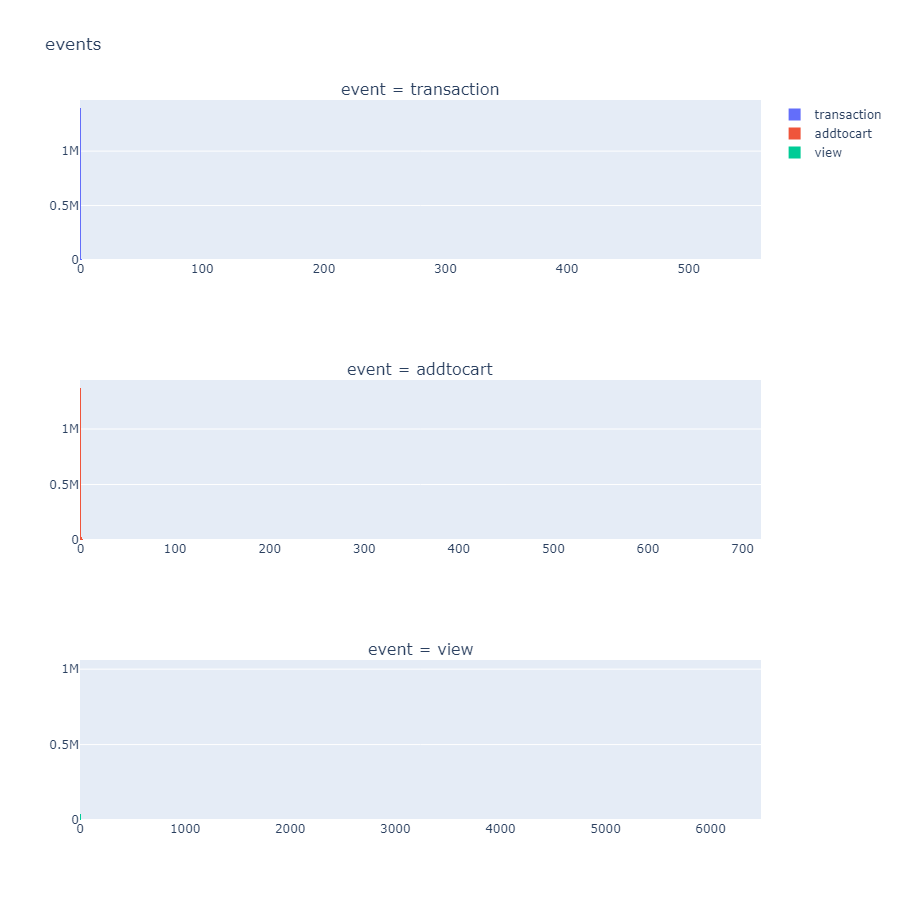

In [12]:
events_pivot = events.pivot_table(
    index='visitorid',
    columns='event',
    aggfunc='size',
    fill_value=0
)

fig = make_subplots(rows=3, cols=1,
                    subplot_titles=['event = transaction',
                                    'event = addtocart',
                                    'event = view',
                                    ])

trace00 = go.Histogram(x=events_pivot['transaction'],
                       orientation='v',
                       name='transaction')
trace01 = go.Histogram(x=events_pivot['addtocart'],
                       orientation='v',
                       name='addtocart')
trace02 = go.Histogram(x=events_pivot['view'],
                       orientation='v',
                       name='view')


fig.append_trace(trace00, 1, 1)
fig.append_trace(trace01, 2, 1)
fig.append_trace(trace02, 3, 1)


fig.update_layout(height=900,
                  width=900,
                  title_text='events')
fig.write_html("images/graf2.html")
fig.write_image('images/img2.png')

fig.show('png')

На лицо море "ненормальных" пользователей у которых больше 6000 просмотров товаров, больше 500 addtocart и больше 500 транзакций. Такие пользователи только будут мешать обучению моделей.

Проверю на наличие "мертвых пользователей"

In [13]:
null_user = events_pivot[(events_pivot['transaction'] == 0) & (events_pivot['addtocart'] == 0) & (events_pivot['view'] == 0)].index
null_user

Index([], dtype='int64', name='visitorid')

In [14]:
odd_user = events_pivot[(events_pivot['transaction'] > 27) | (events_pivot['addtocart'] > 75) | (events_pivot['view'] > 255)].index
print(odd_user)
print(events.shape)
events = events[~events.visitorid.isin(odd_user)]
print(events.shape)

Index([   6958,   17676,   38015,   48820,   53842,   54791,   57905,   73449,
         76757,   77390,
       ...
       1297062, 1313381, 1327144, 1332095, 1336835, 1348163, 1357576, 1376763,
       1385073, 1403769],
      dtype='int64', name='visitorid', length=150)
(2755641, 13)
(2635971, 13)


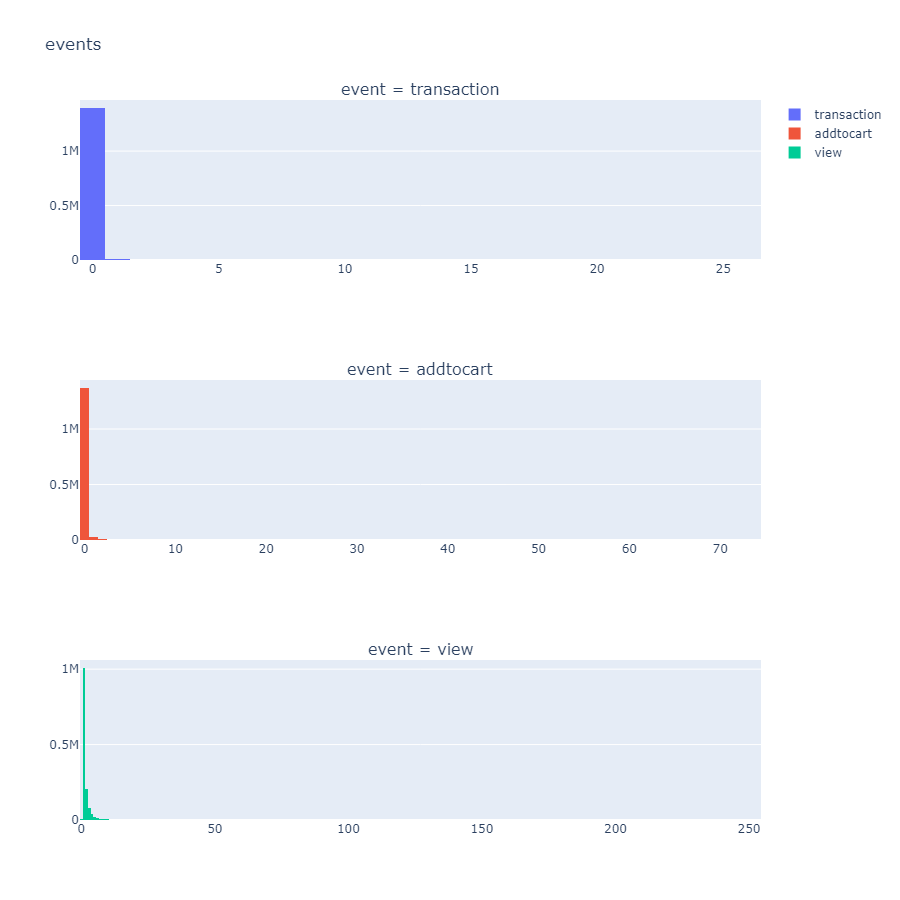

In [15]:
events_pivot = events.pivot_table(
                                index='visitorid',
                                columns='event',
                                aggfunc='size',
                                fill_value=0
                                )

fig = make_subplots(rows=3,
                    cols=1,
                    subplot_titles=['event = transaction',
                                    'event = addtocart',
                                    'event = view',
                                    ])

trace00 = go.Histogram(x=events_pivot['transaction'],
                       orientation='v',
                       name='transaction')
trace01 = go.Histogram(x=events_pivot['addtocart'],
                       orientation='v',
                       name='addtocart',)
trace02 = go.Histogram(x=events_pivot['view'],
                       orientation='v',
                       name='view')


fig.append_trace(trace00, 1, 1)
fig.append_trace(trace01, 2, 1)
fig.append_trace(trace02, 3, 1)


fig.update_layout(height=900,
                  width=900,
                  title_text='events').show('png')
fig.write_html("images/graf3.html")
fig.write_image('images/img3.png')

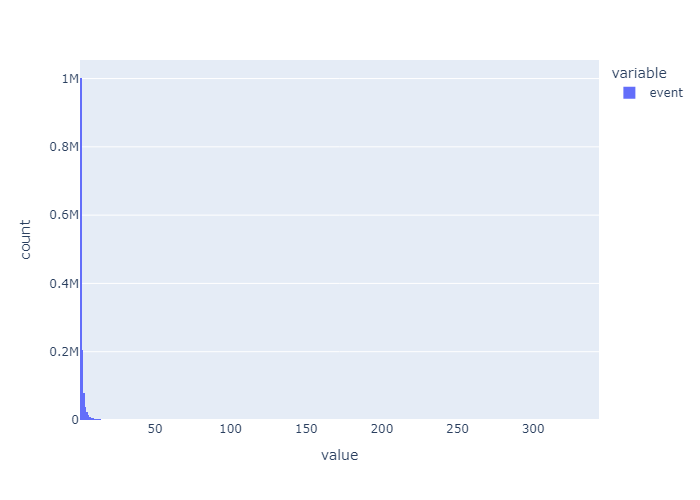

In [16]:
temp = events.groupby('visitorid', as_index=False)['event'].count()
px.histogram(temp['event']).show('png')
fig.write_html("images/graf4.html")
fig.write_image('images/img4.png')

Буду рассматривать только активных пользователей.

In [17]:
print(events.shape)
active_user =  events[events['event'] == 'transaction'].visitorid.unique().tolist()
# top_active_user = events.groupby('visitorid', as_index=False)['event'].count()
# top_active_user = top_active_user[(top_active_user['event'] > 20)]['visitorid'].unique().tolist()
# active_user.extend(top_active_user)
# active_user = set(active_user)
events = events[events.visitorid.isin(active_user)]
print(events.shape)

(2635971, 13)
(135834, 13)


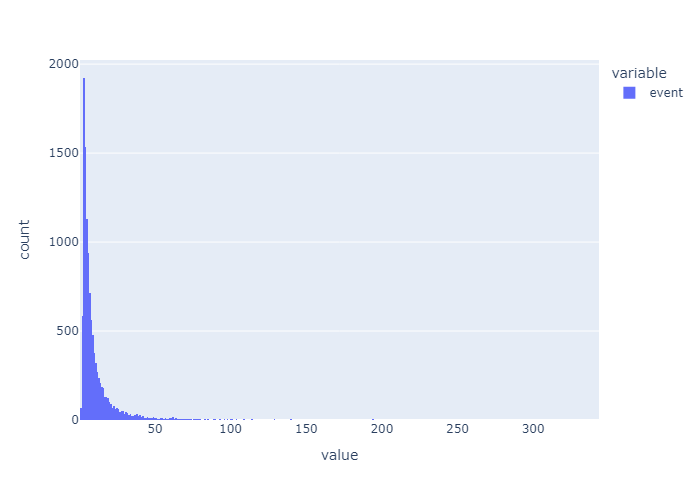

In [18]:
temp = events.groupby('visitorid', as_index=False)['event'].count()
fig_events_grb = px.histogram(temp['event'])
fig_events_grb.write_html("images/graf5.html")
fig_events_grb.write_image('images/img5.png')
fig_events_grb.show('png')

Найду популярные товары и ими ограничу выборку
* найду товары, которые покупали больше **3 раз**
* найду товары по которым происходили события более **10 раз**


Обединю эти списки и отфильтрую.  
И заодно удалю лишние товары из item_properties, чтобы упростить работу (меньше данных - быстрее работа) практически при той же точности

In [19]:
events.shape

(135834, 13)

In [20]:
top_item_sale = events[events['event'] == 'transaction'].groupby('itemid', as_index=False)['event'].count()
top_item_sale = top_item_sale[(top_item_sale['event'] > 3)]['itemid'].unique().tolist()
print(len(top_item_sale))


top_item = events.groupby('itemid', as_index=False)['event'].count()
top_item = top_item[(top_item['event'] > 10)]
top_item = top_item['itemid'].unique().tolist()
print(len(top_item))


top_item.extend(top_item_sale)
top_item = set(top_item)
len(top_item)

events = events[events['itemid'].isin(top_item)]
events.shape

688
3026


(64096, 13)

In [21]:
temp = events[events['event'] == 'transaction'].groupby('itemid', as_index=False)['event'].count().sort_values('event', ascending=False)
px.histogram(temp['event'],
             marginal='box')

In [22]:
temp = events.groupby('itemid', as_index=False)['event'].count().sort_values('event', ascending=False)
px.histogram(temp['event'],
             marginal='box')

In [23]:
itemid_unique = events['itemid'].unique()

In [24]:
display(category_tree.describe(include='all'))

print(category_tree.isna().mean())
category_tree = category_tree.dropna()

,categoryid,parentid
count,1669.000000,1644.000000
mean,849.285201,847.571168
std,490.195116,505.058485
min,0.000000,8.000000
25%,427.000000,381.000000
50%,848.000000,866.000000
75%,1273.000000,1291.000000
max,1698.000000,1698.000000


categoryid    0.000000
parentid      0.014979
dtype: float64


In [25]:
item_properties = item_properties[item_properties['itemid'].isin(itemid_unique)]
item_properties

,timestamp,itemid,property,value
104,2015-05-17,329408,888,1333963 747375 927741 1071593 547687 199524
112,2015-08-09,388318,928,726612 1318567
201,2015-08-16,104468,451,680408
227,2015-05-10,238394,159,519769
296,2015-09-13,366228,available,1
...,...,...,...,...
20275589,2015-06-28,411482,888,46059 449220 n348.000 424566 714364 784581 120...
20275600,2015-06-28,30024,available,1
20275679,2015-07-05,294287,790,n58800.000
20275798,2015-06-07,140861,888,n13308.000 1133979


In [26]:
display(item_properties.describe(include='all'))

,timestamp,itemid,property,value
count,219842,219842.000000,219842,219842
unique,NaN,NaN,805,25466
top,NaN,NaN,790,1
freq,NaN,NaN,49840,23705
mean,2015-07-03 00:24:31.820671488,236723.132936,NaN,NaN
min,2015-05-10 00:00:00,25.000000,NaN,NaN
25%,2015-05-31 00:00:00,123995.000000,NaN,NaN
50%,2015-06-28 00:00:00,239581.000000,NaN,NaN
75%,2015-08-09 00:00:00,350270.000000,NaN,NaN
max,2015-09-13 00:00:00,466321.000000,NaN,NaN


In [27]:
item_properties.isna().mean()

timestamp    0.0
itemid       0.0
property     0.0
value        0.0
dtype: float64

In [28]:
item_properties.sort_values(['timestamp', 'itemid'])[:25]

,timestamp,itemid,property,value
2824514,2015-05-10,25,790,n46800.000
4946462,2015-05-10,25,112,679677
5372281,2015-05-10,25,364,316529
7786530,2015-05-10,25,categoryid,1509
8096336,2015-05-10,25,6,1272323
10510907,2015-05-10,25,available,1
15009115,2015-05-10,25,159,519769
17081164,2015-05-10,25,888,418093 1231777
18035490,2015-05-10,25,917,n1092.000 15252
2076302,2015-05-10,147,888,229273 388993 1246541 321954 1079844 1103209


In [29]:
item_properties.shape

(219842, 4)

In [30]:
temp = []
item_properties.property.apply(lambda x: x if x.isdigit() else temp.append(x))
set(temp)

{'available', 'categoryid'}

In [31]:
categoryid_properties = item_properties[item_properties['property'] == 'categoryid'].sort_values('itemid', ignore_index=True)
categoryid_properties = categoryid_properties.rename(columns={"value":"categoryid"}).drop('property', axis=1)
categoryid_properties.categoryid = categoryid_properties.categoryid.astype('int')
categoryid_properties[categoryid_properties['itemid'] == 25].sort_values('timestamp')

,timestamp,itemid,categoryid
12,2015-05-10,25,1509
10,2015-05-17,25,1509
8,2015-05-24,25,1509
5,2015-05-31,25,1509
16,2015-06-07,25,1509
15,2015-06-14,25,1509
6,2015-06-28,25,1509
2,2015-07-05,25,1509
14,2015-07-12,25,1509
3,2015-07-19,25,1509


In [32]:
available = item_properties[item_properties['property'] == 'available'].sort_values('timestamp', ignore_index=True)
available = available.rename(columns={"value":"available"}).drop('property', axis=1)
available[available['itemid'] == 25].sort_values('timestamp')

,timestamp,itemid,available
1089,2015-05-10,25,1
3959,2015-05-17,25,1
4457,2015-05-24,25,1
7422,2015-05-31,25,0
9121,2015-06-07,25,1
11291,2015-06-14,25,0
12303,2015-06-28,25,1
15456,2015-07-05,25,1
16302,2015-07-12,25,1
18844,2015-07-19,25,1


In [33]:
available.isna().mean()

timestamp    0.0
itemid       0.0
available    0.0
dtype: float64

In [34]:
start_date = available['timestamp'].min()
end_date = available['timestamp'].max()
# # Применение функции к каждой группе пользователей
available_full = available.groupby('itemid').apply(add_missing_sundays,
                                                   start_date=start_date,
                                                   end_date=end_date).ffill().bfill().reset_index(drop=True)

available_full.available = available_full.available.astype('int8')

In [35]:
# # Производим сериализацию и записываем результат в файл формата pkl
with open('data/available_full.pkl', 'wb') as output:
    pickle.dump(available_full, output)

# # Производим десериализацию и извлекаем из файла формата pkl
with open('data/available_full.pkl', 'rb') as pkl_file:
    available_full = pickle.load(pkl_file)

In [36]:
available_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56126 entries, 0 to 56125
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timestamp  56126 non-null  datetime64[ns]
 1   itemid     56126 non-null  float64       
 2   available  56126 non-null  int8          
dtypes: datetime64[ns](1), float64(1), int8(1)
memory usage: 931.9 KB


In [37]:
# Пример
available_full[available_full['itemid'] == 48696].sort_values('timestamp')[:25]

,timestamp,itemid,available


In [38]:
print('shape categoryid_properties : ', categoryid_properties.shape)
print('shape available_full : ', available_full.shape)

shape categoryid_properties :  (6151, 3)
shape available_full :  (56126, 3)


In [39]:
categoryid_properties = categoryid_properties.merge(category_tree, on='categoryid', how='left')
# display(categoryid_properties)
print('shape categoryid_properties : ', categoryid_properties.shape)
print(categoryid_properties['parentid'].isna().sum())
categoryid_properties = categoryid_properties.dropna()
print(categoryid_properties['parentid'].isna().sum())
print('shape categoryid_properties : ', categoryid_properties.shape)

shape categoryid_properties :  (6151, 4)
0
0
shape categoryid_properties :  (6151, 4)


In [40]:
cat_prop_full = categoryid_properties.groupby('itemid').apply(add_missing_sundays,
                                                        start_date=start_date,
                                                        end_date=end_date).ffill().bfill().reset_index(drop=True)
cat_prop_full.shape

(56126, 4)

In [41]:
# Производим сериализацию и записываем результат в файл формата pkl
with open('data/cat_prop_full.pkl', 'wb') as output:
    pickle.dump(cat_prop_full, output)

# # # Производим десериализацию и извлекаем из файла формата pkl
with open('data/cat_prop_full.pkl', 'rb') as pkl_file:
    cat_prop_full = pickle.load(pkl_file)

In [42]:
# Пример
cat_prop_full[cat_prop_full['itemid'] == 48696].sort_values('timestamp')[:25]

,timestamp,itemid,categoryid,parentid


In [43]:
print(cat_prop_full['parentid'].isna().sum())
print('shape categoryid_properties : ', cat_prop_full.shape)

0
shape categoryid_properties :  (56126, 4)


In [44]:
cat_prop_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56126 entries, 0 to 56125
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   timestamp   56126 non-null  datetime64[ns]
 1   itemid      56126 non-null  float64       
 2   categoryid  56126 non-null  float64       
 3   parentid    56126 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.7 MB


In [45]:
itm_prop = item_properties[(item_properties['property'] != 'available') & (item_properties['property'] != 'categoryid')]
display(itm_prop.info())
display(itm_prop.head())

<class 'pandas.core.frame.DataFrame'>
Index: 178066 entries, 104 to 20275798
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   timestamp  178066 non-null  datetime64[ns]
 1   itemid     178066 non-null  int64         
 2   property   178066 non-null  object        
 3   value      178066 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 6.8+ MB


None

,timestamp,itemid,property,value
104,2015-05-17,329408,888,1333963 747375 927741 1071593 547687 199524
112,2015-08-09,388318,928,726612 1318567
201,2015-08-16,104468,451,680408
227,2015-05-10,238394,159,519769
406,2015-05-10,194830,283,1206195 1318713 972907 214729


In [46]:
display(itm_prop.info())

<class 'pandas.core.frame.DataFrame'>
Index: 178066 entries, 104 to 20275798
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   timestamp  178066 non-null  datetime64[ns]
 1   itemid     178066 non-null  int64         
 2   property   178066 non-null  object        
 3   value      178066 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 6.8+ MB


None

In [47]:
itm_prop = itm_prop.merge(cat_prop_full, on=['timestamp', 'itemid'], how='left')
itm_prop = itm_prop.merge(available_full, on=['timestamp', 'itemid'], how='left')
itm_prop = itm_prop.sort_values('timestamp')

In [48]:
itm_prop.isna().mean()*100

timestamp     0.0
itemid        0.0
property      0.0
value         0.0
categoryid    0.0
parentid      0.0
available     0.0
dtype: float64

In [49]:
itm_prop = itm_prop.fillna(1111111111)
itm_prop.isna().mean()*100

timestamp     0.0
itemid        0.0
property      0.0
value         0.0
categoryid    0.0
parentid      0.0
available     0.0
dtype: float64

In [50]:
itm_prop.shape

(178066, 7)

In [51]:
# # Производим сериализацию и записываем результат в файл формата pkl
with open('data/itm_prop.pkl', 'wb') as output:
    pickle.dump(itm_prop, output)


# # # Производим десериализацию и извлекаем из файла формата pkl
with open('data/itm_prop.pkl', 'rb') as pkl_file:
    itm_prop = pickle.load(pkl_file)

Типы событий ['view', 'addtocart', 'transaction'], их необходимо превести в числовой вид.  
Здесь можно играться с коэффициентами , для улучшения качества. Но так как нас интересуют продажи, то ввела такие коэффициеты.

In [52]:
# event_type = {
#             'view': 1,
#             'addtocart': 2,
#             'transaction': 10,
#             }

# events['event'] = events['event'].replace(event_type)

In [53]:
train, test = train_test_split(events, test_size=0.3, shuffle=False)

print(train.shape[0] / events.shape[0])
print(test.shape[0] / events.shape[0])

0.6999968796804793
0.3000031203195207


In [54]:
# Построен валидационный датасет (разбивка по времени)
# На мой взгляд так более правильно (в соответствии с заданием)

split_date = '2015-07-29' # Почему именно такая дата: чтобы разбика примерно была  в соотношении как в эталонном примере 70:30
train_time = events[events['timestamp'].dt.strftime('%Y-%m-%d') < split_date]
test_time = events[events['timestamp'].dt.strftime('%Y-%m-%d') >= split_date]

print(train_time.shape[0]/events.shape[0])
print(test_time.shape[0]/events.shape[0])

0.6978126560159761
0.30218734398402397


In [55]:
# # Производим сериализацию и записываем результат в файл формата pkl
with open('data/train_time.pkl', 'wb') as output:
    pickle.dump(train_time, output)

with open('data/test_time.pkl', 'wb') as output:
    pickle.dump(test_time, output)

# Создание факторов для модели

Факторы в рекомендательных системах — это скрытые переменные, которые описывают взаимодействия пользователей и объектов (например, товаров или фильмов). Эти факторы помогают предсказать предпочтения пользователей. Проще говоря, факторы — это параметры, которые используются для создания персонализированных рекомендаций.

Примеры факторов:  
* Пользовательские предпочтения: Интересы, возраст, пол, прошлые действия, история покупок и просмотров.
* Свойства объектов: Жанр фильма, категория товара, цена, рейтинг.
* Контекст: Время суток, место нахождения, устройство, с которого выполняется доступ.

Каждый пользователь и каждый объект могут быть представлены как векторы в пространстве факторов. Модель пытается минимизировать ошибку предсказания, находя оптимальные векторы для пользователей и объектов, чтобы сделать точные рекомендации.

Временные факторы созданы в ноутбуке **first_second_week.ipynb**


### Генерация факторов айтем-юзер

Генерация факторов айтем-юзер

Генерация факторов, связанных как с пользователями (юзерами), так и с айтемами (объектами), позволяет создать более точные и персонализированные рекомендации. Давай рассмотрим, какие факторы можно использовать:

Факторы пользователей:
* История покупок/просмотров: Какие товары пользователь уже покупал или просматривал.
* Возраст, пол, местоположение: Демографическая информация.
* Интересы и предпочтения: Например, жанры фильмов или категории товаров.
Взаимодействия с системой: Лайки, отзывы, время, проведенное на сайте.

Факторы айтемов:
* Категория: Классификация товара.
* Бренд: Производитель или марка.
* Цена: Стоимость.
* Рейтинг: Средние оценки пользователей.
* Описание: Текстовое описание или ключевые слова.
* Изображения: Визуальные характеристики.

In [56]:
# Создание разреженной матрицы item-user
# train_item_user_matrix = csr_matrix((train['event'], (train['itemid'], train['visitorid'])))
# test_item_user_matrix = csr_matrix((test['event'], (test['itemid'], test['visitorid'])))

# item_user_matrix = csr_matrix((events['event'], (events['itemid'], events['visitorid'])))

### Генерация факторов, связанных с айтемами

Генерация факторов, связанных с айтемами (items), — ключевой процесс в рекомендательных системах. Эти факторы помогают системе лучше понять и предсказать предпочтения пользователей. Вот примеры таких факторов:

* Категория: Определенная категория, к которой относится товар (например, книги, электроника, одежда).  
* Бренд: Название бренда или производителя товара.  
* Цена: Стоимость товара.  
* Рейтинг: Оценки, оставленные пользователями.  
* Дата выпуска: Когда товар был впервые выпущен или добавлен в систему.  
* Текстовое описание: Ключевые слова из описания или названия товара.  
* Изображения: Особенности изображений товаров, такие как цвет, форма и др.  
* Популярность: Сколько раз товар был просмотрен или куплен пользователями.  

Использование этих факторов позволяет системе предоставлять более точные и персонализированные рекомендации.

Воспользуюсь подсказкой ментора из Пачки

In [57]:
# # Инициализация ALS модели
# als_model = AlternatingLeastSquares(factors=100,
#                                     regularization=0.1,
#                                     iterations=100,
#                                     num_threads = num_threads )

# # Обучение модели ALS
# als_model.fit(item_user_matrix)

# # Получение факторов для айтемов
# item_factors = als_model.item_factors

# # Создание DataFrame с факторами айтемов
# item_factors_df = pd.DataFrame(item_factors, index=range(1, item_factors.shape[0] + 1), columns=[f'item_factor_{i}' for i in range(item_factors.shape[1])])

# # Добавление факторов айтемов к исходному датасету с айтемами

# events = pd.merge(events, item_factors_df, left_on='itemid', right_index=True, how='left')

# events.head(3)

In [58]:
# # Производим сериализацию и записываем результат в файл формата pkl
with open('data/events_cl.pkl', 'wb') as output:
    pickle.dump(events, output)

In [59]:
events

,timestamp,visitorid,event,itemid,transactionid,day_of_week,year,month,day,hour,minute,part_day,Day Period
19,2015-06-02 04:57:58.505,158090,addtocart,10572,NaN,1,2015,6,2,4,57,Night,Dawn
35,2015-06-02 05:57:24.638,361387,view,43485,NaN,1,2015,6,2,5,57,Morning,Dawn
110,2015-06-02 05:09:00.333,712443,view,346655,NaN,1,2015,6,2,5,9,Morning,Dawn
112,2015-06-02 05:12:21.632,599528,addtocart,356475,NaN,1,2015,6,2,5,12,Morning,Dawn
130,2015-06-02 05:17:56.276,599528,transaction,356475,4000.0,1,2015,6,2,5,17,Morning,Dawn
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2755722,2015-08-01 05:48:33.771,674837,view,47043,NaN,5,2015,8,1,5,48,Morning,Dawn
2755852,2015-08-01 05:44:10.879,140572,view,396930,NaN,5,2015,8,1,5,44,Morning,Dawn
2755945,2015-08-01 02:47:43.804,532307,view,89232,NaN,5,2015,8,1,2,47,Night,Night
2755952,2015-08-01 03:03:25.600,1016212,view,162038,NaN,5,2015,8,1,3,3,Night,Dawn


Следующая часть для LightFM

In [60]:
col = ['timestamp', 'visitorid', 'event', 'itemid', 'day_of_week', 'year', 'month', 'day', 'hour', 'minute', 'Day Period',]

itm_prop = itm_prop[['timestamp', 'itemid', 'categoryid', 'parentid']]
itm_prop= itm_prop.drop_duplicates()
events = events[col]
events.loc[:, 'timestamp'] = pd.to_datetime(events['timestamp'].dt.strftime('%Y-%m-%d'))
display(itm_prop.head(1))
display(events.head(1))


start_date = min(itm_prop['timestamp'].min(), events['timestamp'].min())
end_date = max(itm_prop['timestamp'].max(), events['timestamp'].max())


itm_prop = itm_prop.groupby('itemid').apply(add_missing_days,
                                    start_date=start_date,
                                    end_date=end_date).ffill().bfill().reset_index(drop=True)
events = events.merge(itm_prop, on=['timestamp', 'itemid'], how='left')


available_full = available_full.groupby('itemid').apply(add_missing_days,
                                                start_date=start_date,
                                                end_date=end_date).ffill().bfill().reset_index(drop=True)
events = events.merge(available_full, on=['timestamp', 'itemid'], how='left')


display(events.isna().mean())
events = events.dropna()

,timestamp,itemid,categoryid,parentid
24666,2015-05-10,28307,1589.0,1426.0


,timestamp,visitorid,event,itemid,day_of_week,year,month,day,hour,minute,Day Period
19,2015-06-02,158090,addtocart,10572,1,2015,6,2,4,57,Dawn


timestamp      0.000000
visitorid      0.000000
event          0.000000
itemid         0.000000
day_of_week    0.000000
year           0.000000
month          0.000000
day            0.000000
hour           0.000000
minute         0.000000
Day Period     0.000000
categoryid     0.018987
parentid       0.018987
available      0.018987
dtype: float64

In [61]:
available_full

,timestamp,itemid,available
0,2015-05-03,25.0,1.0
1,2015-05-04,25.0,1.0
2,2015-05-05,25.0,1.0
3,2015-05-06,25.0,1.0
4,2015-05-07,25.0,1.0
...,...,...,...
410601,2015-09-14,466321.0,1.0
410602,2015-09-15,466321.0,1.0
410603,2015-09-16,466321.0,1.0
410604,2015-09-17,466321.0,1.0


In [ ]:
available_only = available_full[available_full['available'] == 1]
with open('data/available_only.pkl', 'wb') as output:
    pickle.dump(available_only, output)

In [63]:
with open('lightfm/data/itm_prop.pkl', 'wb') as output:
    pickle.dump(itm_prop, output)

with open('lightfm/data/available_full.pkl', 'wb') as output:
    pickle.dump(available_full, output)

with open('lightfm/data/events_1.pkl', 'wb') as output:
    pickle.dump(events, output)

In [64]:
events.info()

<class 'pandas.core.frame.DataFrame'>
Index: 62879 entries, 0 to 64095
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    62879 non-null  datetime64[ns]
 1   visitorid    62879 non-null  int64         
 2   event        62879 non-null  object        
 3   itemid       62879 non-null  int64         
 4   day_of_week  62879 non-null  int32         
 5   year         62879 non-null  int32         
 6   month        62879 non-null  int32         
 7   day          62879 non-null  int32         
 8   hour         62879 non-null  int32         
 9   minute       62879 non-null  int32         
 10  Day Period   62879 non-null  object        
 11  categoryid   62879 non-null  float64       
 12  parentid     62879 non-null  float64       
 13  available    62879 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int32(6), int64(2), object(2)
memory usage: 5.8+ MB


In [65]:
events

,timestamp,visitorid,event,itemid,day_of_week,year,month,day,hour,minute,Day Period,categoryid,parentid,available
0,2015-06-02,158090,addtocart,10572,1,2015,6,2,4,57,Dawn,1037.0,402.0,1.0
2,2015-06-02,712443,view,346655,1,2015,6,2,5,9,Dawn,1220.0,125.0,1.0
3,2015-06-02,599528,addtocart,356475,1,2015,6,2,5,12,Dawn,386.0,1095.0,1.0
4,2015-06-02,599528,transaction,356475,1,2015,6,2,5,17,Dawn,386.0,1095.0,1.0
5,2015-06-01,820159,view,369447,0,2015,6,1,21,18,Evening,48.0,500.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64091,2015-08-01,674837,view,47043,5,2015,8,1,5,48,Dawn,1277.0,312.0,0.0
64092,2015-08-01,140572,view,396930,5,2015,8,1,5,44,Dawn,782.0,1562.0,1.0
64093,2015-08-01,532307,view,89232,5,2015,8,1,2,47,Night,1051.0,955.0,0.0
64094,2015-08-01,1016212,view,162038,5,2015,8,1,3,3,Dawn,1250.0,1423.0,1.0


In [66]:
available = pd.read_pickle('lightfm/data/available_full.pkl')
available

,timestamp,itemid,available
0,2015-05-03,25.0,1.0
1,2015-05-04,25.0,1.0
2,2015-05-05,25.0,1.0
3,2015-05-06,25.0,1.0
4,2015-05-07,25.0,1.0
...,...,...,...
410601,2015-09-14,466321.0,1.0
410602,2015-09-15,466321.0,1.0
410603,2015-09-16,466321.0,1.0
410604,2015-09-17,466321.0,1.0


In [67]:
events_impl = events.drop(['day_of_week', 'year', 'month', 'day', 'hour', 'minute', 'Day Period', 'categoryid', 'parentid'], axis=1)
events_impl = events_impl[events_impl['available'] == 1]
with open('data/events_impl.pkl', 'wb') as output:
    pickle.dump(events_impl, output)

In [68]:
events_impl

,timestamp,visitorid,event,itemid,available
0,2015-06-02,158090,addtocart,10572,1.0
2,2015-06-02,712443,view,346655,1.0
3,2015-06-02,599528,addtocart,356475,1.0
4,2015-06-02,599528,transaction,356475,1.0
5,2015-06-01,820159,view,369447,1.0
...,...,...,...,...,...
64089,2015-07-31,218648,view,89076,1.0
64090,2015-07-31,572806,view,104781,1.0
64092,2015-08-01,140572,view,396930,1.0
64094,2015-08-01,1016212,view,162038,1.0


In [69]:
top = events_impl[events_impl['event'] == 'transaction'].groupby('itemid', as_index=False)['event'].count().sort_values('event', ascending=False)[:3]
top = top.itemid.to_list()
top

[461686, 213834, 7943]